# Geographical Visualizations with Python

#### This script contains the following:
1. Importing libraries and data
2. Creating choropleth map
3. Result discussion

#### 1. Importing libraries and data

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import os

In [2]:
#creating path for easier import
path = r'C:\Users\magia\NY CitiBike'

In [3]:
# importing dataset
df = pd.read_csv(os.path.join(path, '2. Data', 'Prepared Data', 'citibike_cleaned.csv', index = False))

In [22]:
!pip install geopandas

In [23]:
import geopandas as gpd
from shapely.geometry import Point

# Create GeoDataFrame from station coordinates
geometry = [Point(xy) for xy in zip(df['start_station_longitude'], df['start_station_latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load shapefile of NYC Neighborhood Tabulation
nyc_regions = gpd.read_file('nynta2020.shp') 

# Spatial join to get the region for each station
gdf_with_region = gpd.sjoin(gdf, nyc_regions, how="left", predicate="within")

C:\Users\magia\AppData\Local\Temp\ipykernel_20444\3370649646.py:12: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:2263

  gdf_with_region = gpd.sjoin(gdf, nyc_regions, how="left", predicate="within")


In [24]:
# Reprojecting points GeoDataFrame to the CRS of nyc_regions
gdf = gdf.to_crs(nyc_regions.crs)

# Performing spatial join
gdf_with_region = gpd.sjoin(gdf, nyc_regions, how="left", predicate="within")

In [26]:
# confirming join
print(nyc_regions.columns)

Index(['BoroCode', 'BoroName', 'CountyFIPS', 'NTA2020', 'NTAName', 'NTAAbbrev',
       'NTAType', 'CDTA2020', 'CDTAName', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


In [27]:
# adding neighborhood names to stations gdf
gdf_with_region['neighborhood'] = gdf_with_region['NTAName']

In [ ]:
print(gdf_with_region.columns)
print(gdf_with_region.head())

Creating choropleth map of trip counts per neighborhood using merged GeoDataFrame and neighborhood polygons

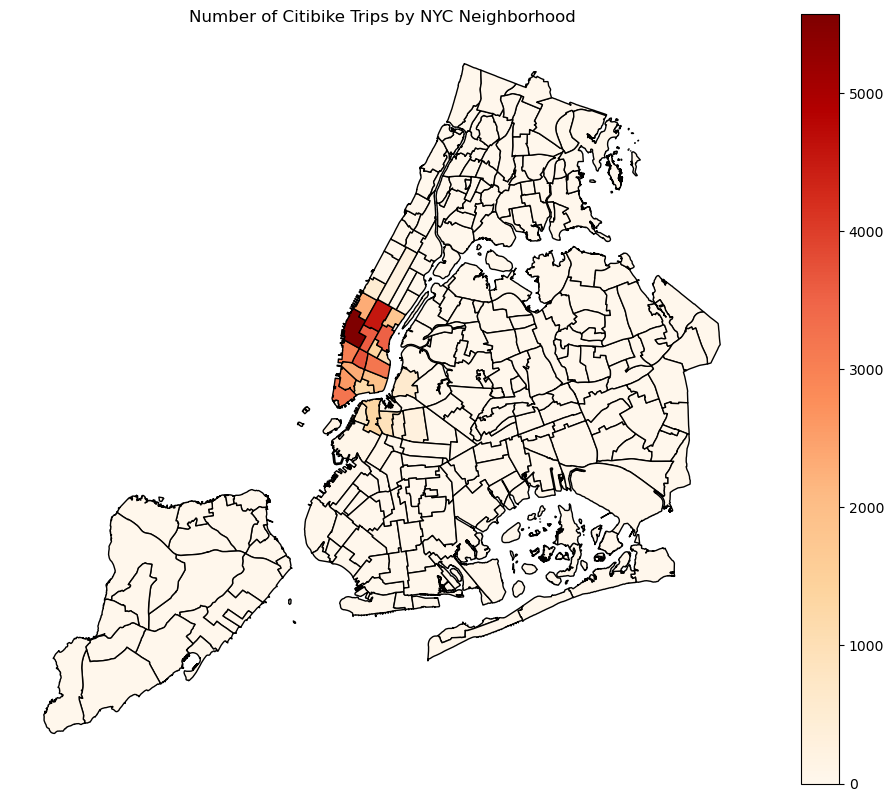

In [30]:
import matplotlib.pyplot as plt

# Group by neighborhood and count trips
trips_per_neighborhood = gdf_with_region.groupby('neighborhood').size().reset_index(name='trip_count')

# Merge trip counts back to the neighborhood polygons GeoDataFrame
nyc_regions = nyc_regions.merge(trips_per_neighborhood, left_on='NTAName', right_on='neighborhood', how='left')
nyc_regions['trip_count'] = nyc_regions['trip_count'].fillna(0)  # Replace NaNs with 0

# Plot choropleth
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
nyc_regions.plot(column='trip_count', ax=ax, legend=True, cmap='OrRd', edgecolor='black')
ax.set_title('Number of Citibike Trips by NYC Neighborhood')
ax.axis('off')
plt.show()

Citibike in 2013 was heavily concentrated in Lower Manhattan and parts of Brooklyn. Uptown, Queens, and the Bronx weren’t really part of the network yet — so it makes sense those areas show 0 trips (or NaNs).